## 1.1 Objectif de l’atelier  
L’objectif est de **construire, entraîner et comparer** un modèle MLP puis un CNN pour la classification d’images du dataset Fashion-MNIST.  
On applique des techniques de régularisation pour éviter l’overfitting, puis on interprète les résultats à l’aide de méthodes d’**Explainable AI** comme Grad-CAM pour visualiser où le modèle "regarde".

---

## 1.2 Pourquoi choisir Fashion-MNIST ?  
- Dataset remplaçant le classique MNIST, mais plus réaliste : images d’articles vestimentaires (T-shirts, chaussures, sacs, etc.).  
- 70 000 images 28×28 pixels en niveaux de gris, réparties en 10 classes.  
- Plus difficile que MNIST : accuracy CNN ≈ 90-95% vs ~99% sur MNIST.  
- Parfait pour tester un CNN basique et introduire des techniques avancées (régularisation, explicabilité).  
*Référence : [Zalando Research, 2017]*

---

## 1.3 Architectures MLP vs CNN

### MLP (Multilayer Perceptron)  
- Structure : entrée aplatie (28×28 → 784 features) → Dense → ReLU → Dense → Softmax.  
- Problème : ignore la structure spatiale des images.  
- Grand nombre de paramètres → coûteux à entraîner, moins performant pour l’image.

### CNN (Convolutional Neural Network)  
- Utilise des filtres convolutifs (kernels) glissant sur l’image, capturant motifs locaux (bords, textures…).  
- Architecture typique :  
  - Couche `Conv2D(filters, kernel_size, activation='relu')`  
  - `MaxPooling2D(pool_size=(2,2))` pour réduire la dimension spatiale  
  - Répétition de couches convolution + pooling  
  - Flatten + Dense + Softmax en sortie  
- Avantages :  
  - Partage des poids → moins de paramètres, meilleur apprentissage.  
  - Invariance aux translations (localisation des motifs).  
  - Efficace pour l’image grâce à la hiérarchie des caractéristiques.  
*Référence : [LeCun et al., 1998; Krizhevsky et al., 2012]*

---

## 1.4 Fonctions d’activation & Loss  
- **ReLU (Rectified Linear Unit)** :  
  \[
  f(x) = \max(0, x)
  \]  
  Simple, efficace, réduit le problème du gradient saturé des fonctions sigmoïdes/tanh.  
- **Softmax** : transforme un vecteur de logits en probabilités sommant à 1, idéal pour multi-classes.  
- **Fonction de loss** : `sparse_categorical_crossentropy` adaptée aux labels entiers.  
- **Métrique principale** : précision (`accuracy`) sur train & validation.

---

## 1.5 Surapprentissage (Overfitting) & Régularisation

### Qu’est-ce que l’overfitting ?  
- Le modèle "mémorise" le train, perd en capacité de généralisation.  
- Se manifeste par un écart croissant entre loss train et loss validation.

### Techniques pour le prévenir :  
- **Dropout** : déconnecte aléatoirement des neurones lors de l’entraînement (typ. 0.25–0.5).  
- **EarlyStopping** : stoppe l’entraînement si `val_loss` ne diminue plus (patience=3).  
- **Batch Normalization** : normalise activations en interne, accélère convergence.  
- **Data Augmentation** : rotation, zoom, translation aléatoires pour simuler plus de données.  
- **Régularisation L2 (weight decay)** : pénalise les poids importants.  
*Référence : [Srivastava et al., 2014; Ioffe & Szegedy, 2015]*

---

## 1.6 Explainable AI : Grad-CAM & variantes

### CAM (Class Activation Mapping)  
- Besoin d’une architecture spéciale avec Global Average Pooling (GAP).  
- Permet de visualiser quelles régions activent une classe.

### Grad-CAM (Gradient-weighted CAM)  
- Fonctionne avec tout CNN.  
- Calcul :  
  1. Gradient des logits par rapport aux feature maps d’une couche convolutive.  
  2. Pondération par moyenne globale des gradients (coefficients \(\alpha_k\)).  
  3. Combinaison avec feature maps, passage par ReLU pour obtenir la heatmap.  
- Donne une carte de zones "importantes" pour la classification.

### Avantages & limites  
- Simple, visuel, aide à comprendre et diagnostiquer les erreurs ou biais.  
- Heatmaps parfois floues, pas toujours précises spatialement.  
- Variantes améliorées : Guided Grad-CAM, Grad-CAM++, Score-CAM, Layer-CAM.  
*Référence : [Selvaraju et al., 2017]*

---

## 1.7 Pipeline résumé (flow d’une séance 1h)

| Étape             | But et détails                           |
|-------------------|-----------------------------------------|
| **MLP baseline**   | Benchmark simple, met en lumière limites|
| **CNN simple**     | Architecture convolutive basique        |
| **Régularisation** | Dropout, EarlyStopping, BatchNorm       |
| **Data Augmentation** | Générer diversité & robustesse       |
| **Évaluation**     | Accuracy, loss, matrice de confusion    |
| **Explainability** | Heatmaps Grad-CAM pour interprétation   |

---




In [20]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("zalando-research/fashionmnist")

# print("Path to dataset files:", path)

In [22]:
# import shutil
# import os

# # Dossier source téléchargé par kagglehub
# source_dir = "/home/tegongue/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4"

# # Dossier de destination (à créer s'il n'existe pas)
# destination_dir = "fashionmnist"  # dossier dans le répertoire courant de ton notebook

# # Crée le dossier destination s’il n’existe pas
# os.makedirs(destination_dir, exist_ok=True)

# # Copier tous les fichiers du dossier source vers destination
# for filename in os.listdir(source_dir):
#     src_file = os.path.join(source_dir, filename)
#     dst_file = os.path.join(destination_dir, filename)
#     if os.path.isfile(src_file):
#         shutil.copy(src_file, dst_file)

# print(f"✅ Dataset déplacé dans : {os.path.abspath(destination_dir)}")


# 🧾 Description du dataset : Fashion-MNIST

##  Contexte

**Fashion-MNIST** est un jeu de données d’images développé par **Zalando Research**, visant à **remplacer le dataset MNIST** classique (chiffres manuscrits) dans les benchmarks d’algorithmes de machine learning.

##  Contenu du dataset

- **Taille :**
  - **60 000** exemples d'entraînement
  - **10 000** exemples de test
- **Format des images :** 28×28 pixels, en niveaux de gris
- **Nombre total de pixels :** 784 (28×28)
- **Valeurs des pixels :** entiers entre 0 (blanc) et 255 (noir)
- **Structure des fichiers CSV :** 785 colonnes par ligne
  - Colonne **0** : étiquette (classe de vêtement)
  - Colonnes **1 à 784** : valeurs des pixels (de haut en bas, ligne par ligne)

### Localisation d’un pixel
Soit un pixel d’index `x`. Il correspond à la position `[i, j]` dans l’image 2D si :

```python
i = x // 28
j = x % 28


## Étape 1 : Chargement des datasets

In [30]:
import pandas as pd

# Charger les fichiers
train_df = pd.read_csv("fashionmnist/fashion-mnist_test.csv")
test_df = pd.read_csv("fashionmnist/fashion-mnist_train.csv")


In [34]:
print(train_df)
print(test_df)

      label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0         0       0       0       0       0       0       0       0       9   
1         1       0       0       0       0       0       0       0       0   
2         2       0       0       0       0       0       0      14      53   
3         2       0       0       0       0       0       0       0       0   
4         3       0       0       0       0       0       0       0       0   
...     ...     ...     ...     ...     ...     ...     ...     ...     ...   
9995      0       0       0       0       0       0       0       0       0   
9996      6       0       0       0       0       0       0       0       0   
9997      8       0       0       0       0       0       0       0       0   
9998      8       0       1       3       0       0       0       0       0   
9999      1       0       0       0       0       0       0       0     140   

      pixel9  ...  pixel775  pixel776  pixel777  pi

## Étape 2 : Vue d’ensemble

In [36]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (10000, 785)
Test shape: (60000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Étape 3 : Vérification des valeurs manquantes



In [38]:
print("Missing values in train set:", train_df.isnull().sum().sum())
print("Missing values in test set:", test_df.isnull().sum().sum())


Missing values in train set: 0
Missing values in test set: 0


## Étape 4 : Statistiques sur les pixels

In [40]:
train_df.describe().T.head(10)  # Statistiques pour les 10 premières colonnes


,count,mean,std,min,25%,50%,75%,max
label,10000.0,4.5000,2.872425,0.0,2.0,4.5,7.0,9.0
pixel1,10000.0,0.0004,0.024493,0.0,0.0,0.0,0.0,2.0
pixel2,10000.0,0.0103,0.525187,0.0,0.0,0.0,0.0,45.0
pixel3,10000.0,0.0521,2.494315,0.0,0.0,0.0,0.0,218.0
pixel4,10000.0,0.0770,2.208882,0.0,0.0,0.0,0.0,185.0
pixel5,10000.0,0.2086,4.669183,0.0,0.0,0.0,0.0,227.0
pixel6,10000.0,0.3492,5.657849,0.0,0.0,0.0,0.0,223.0
pixel7,10000.0,0.8267,8.591731,0.0,0.0,0.0,0.0,247.0
pixel8,10000.0,2.3212,15.031508,0.0,0.0,0.0,0.0,218.0
pixel9,10000.0,5.4578,23.359019,0.0,0.0,0.0,0.0,244.0


##  Étape 5 : Répartition des classes

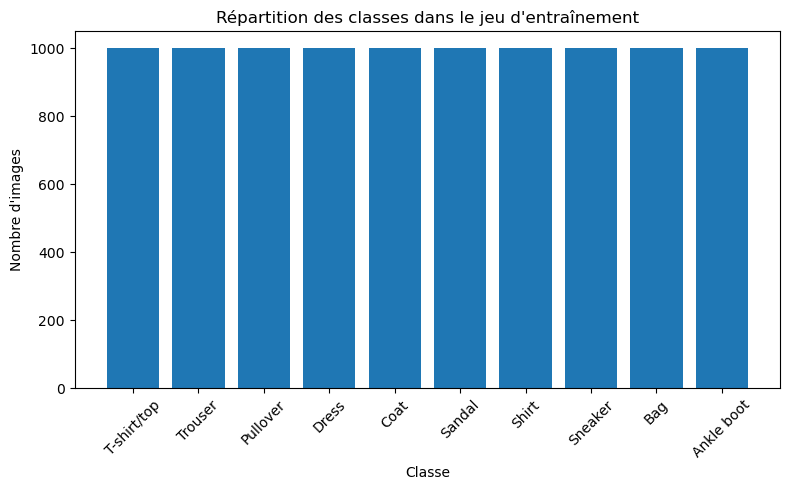

In [105]:
import matplotlib.pyplot as plt

class_counts = train_df['label'].value_counts().sort_index()
labels_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(class_counts.index, [labels_map[i] for i in class_counts.index], rotation=45)
plt.title("Répartition des classes dans le jeu d'entraînement")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.tight_layout()
plt.show()


## Étape 6 : Affichage d’images

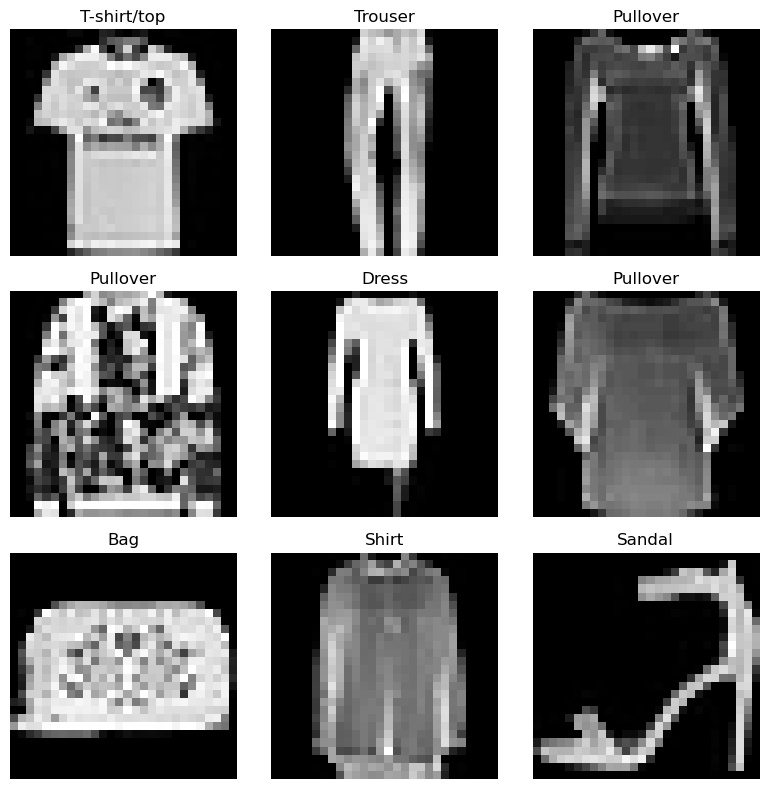

In [44]:
import numpy as np

# Exemple : afficher 9 images
images = train_df.drop('label', axis=1).values
labels = train_df['label'].values

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels_map[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


## Étape 7 : Préparation pour TensorFlow / Keras

### Normalisation des pixels entre 0 et 1

In [47]:
X_train = train_df.drop("label", axis=1).values / 255.0
y_train = train_df["label"].values

X_test = test_df.drop("label", axis=1).values / 255.0
y_test = test_df["label"].values


### Reshape en format image (28, 28, 1) pour CNN

In [50]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)


### One-hot encoding des labels (si softmax)

In [58]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)


In [75]:
# !pip install tensorflow


## Étape 8 : Split train/validation 

In [79]:
from sklearn.model_selection import train_test_split

X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train_cat, test_size=0.2, random_state=42)


## Étape 9 : Construction du modèle CNN


In [81]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Définition du modèle CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')  # 10 classes
])

# Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/home/tegongue/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-23 20:42:58.445242: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

## Étape 10 : Entraînement du modèle

In [84]:
# Entraînement
history = model.fit(
    X_train_part, y_train_part,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val)
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4462 - loss: 1.6082 - val_accuracy: 0.7720 - val_loss: 0.6402
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7289 - loss: 0.7562 - val_accuracy: 0.7825 - val_loss: 0.5651
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7687 - loss: 0.6298 - val_accuracy: 0.8150 - val_loss: 0.4942
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8017 - loss: 0.5549 - val_accuracy: 0.8320 - val_loss: 0.4619
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8156 - loss: 0.4968 - val_accuracy: 0.8400 - val_loss: 0.4459
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8322 - loss: 0.4743 - val_accuracy: 0.8470 - val_loss: 0.4215
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8404 - loss: 0.4454 - val_accuracy: 0.8500 - val_loss: 0.4195
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8445 - loss: 0.4262 - val_accuracy: 0.8565 - v

## Étape 11 : Évaluation du modèle

In [87]:
# Évaluation sur le jeu de test
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"✅ Accuracy sur le jeu de test : {test_acc * 100:.2f}%")


  41/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8471 - loss: 0.4145

2025-07-23 20:45:13.873439: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8634 - loss: 0.3741
✅ Accuracy sur le jeu de test : 86.33%


## Étape 12 : Affichage des courbes d’apprentissage



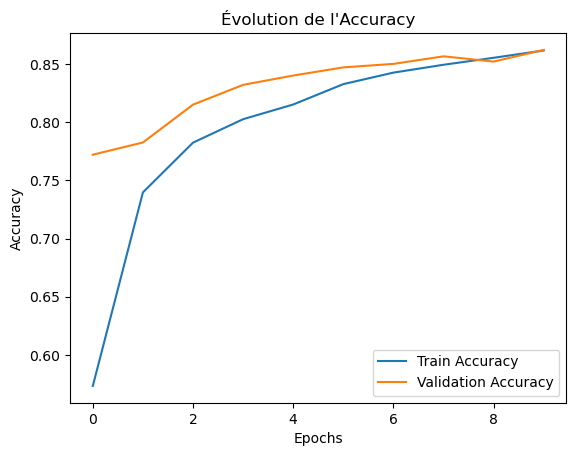

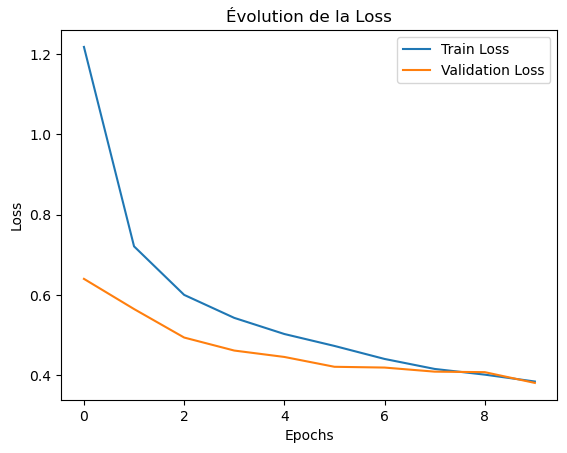

In [90]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Évolution de l'Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Évolution de la Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Étape 13 : Matrice de confusion

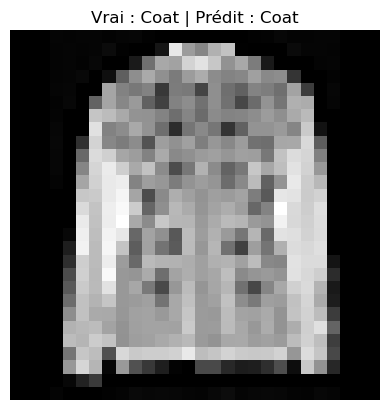

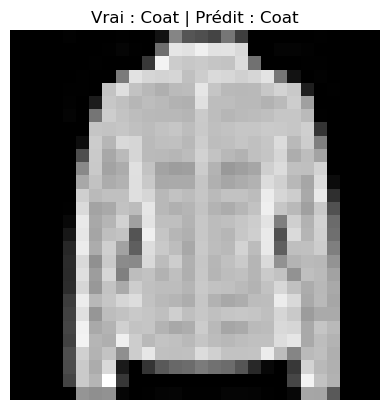

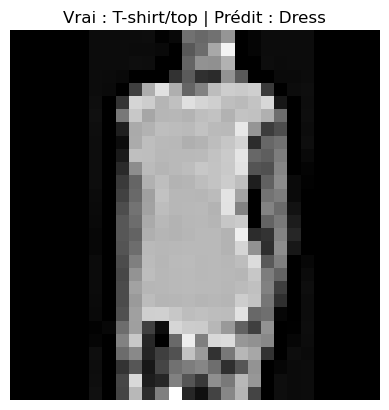

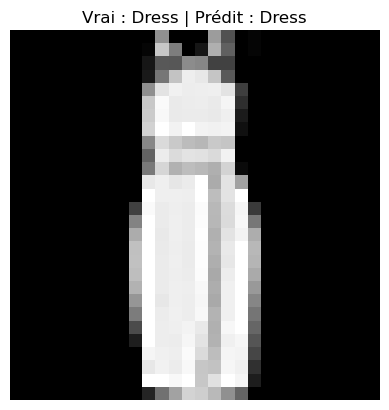

In [100]:
def show_prediction(index):
    # Si les images ont 4 dimensions (batch, height, width, channel)
    image = X_test[index].reshape(28, 28)
    
    # Si y_test est one-hot : true_label = np.argmax(y_test[index])
    true_label = y_test[index]

    prediction = model.predict(X_test[index:index+1], verbose=0)
    pred_label = np.argmax(prediction)

    plt.imshow(image, cmap='gray')
    plt.title(f"Vrai : {labels_map[true_label]} | Prédit : {labels_map[pred_label]}")
    plt.axis('off')
    plt.show()

# Afficher plusieurs exemples
for i in [5, 25, 80, 99]:
    show_prediction(i)


## Étape 14 : Prédictions sur des images individuelles

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


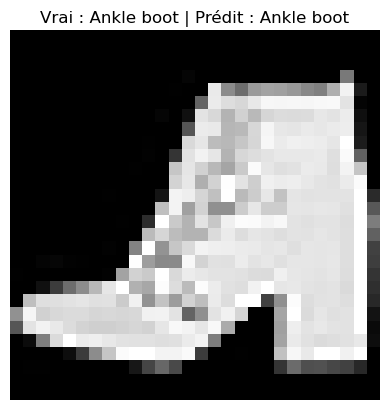

In [102]:
def show_prediction(index):
    image = X_test[index].reshape(28, 28)
    true_label = y_test[index]
    pred_label = np.argmax(model.predict(X_test[index:index+1]))

    plt.imshow(image, cmap='gray')
    plt.title(f"Vrai : {labels_map[true_label]} | Prédit : {labels_map[pred_label]}")
    plt.axis('off')
    plt.show()

# Exemple :
show_prediction(42)
